## Setup and Data Prep

In [ ]:
%pip install -q diffusers  # Installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
# Identify and choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
#Loading the Fahion minst dataset a dataset containing images and numerical class labels
dataset = torchvision.datasets.FashionMNIST(root="FashionMNIST/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 11767687.52it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172774.09it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3224950.23it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17948692.43it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



Input shape: torch.Size([10, 1, 28, 28])
Labels: tensor([1, 9, 3, 9, 5, 7, 5, 8, 3, 0])


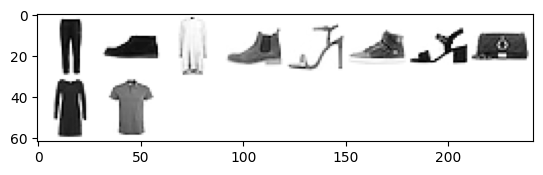

In [ ]:
# Stealing a predefined dataloader to show examples
train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Showing examples from dataset
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [ ]:
class class_conditioned_unet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=100):
    super().__init__()

    # Embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input for class condition
        out_channels=1,           # grea
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # Regular ResNet downsampling block
            "AttnDownBlock2D",    # Downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # forward method  takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to give as additional input
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Expand to contain class embedding

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # concat to one dim input

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
# Create noise
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 50 loss values: 0.089007


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 50 loss values: 0.078131


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 50 loss values: 0.075138


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 50 loss values: 0.075617


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 50 loss values: 0.068723


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 50 loss values: 0.073092


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 50 loss values: 0.070312


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 50 loss values: 0.070301


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 50 loss values: 0.067898


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 50 loss values: 0.068636


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 50 loss values: 0.066133


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 50 loss values: 0.066864


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 50 loss values: 0.069822


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 50 loss values: 0.066691


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 50 loss values: 0.066449


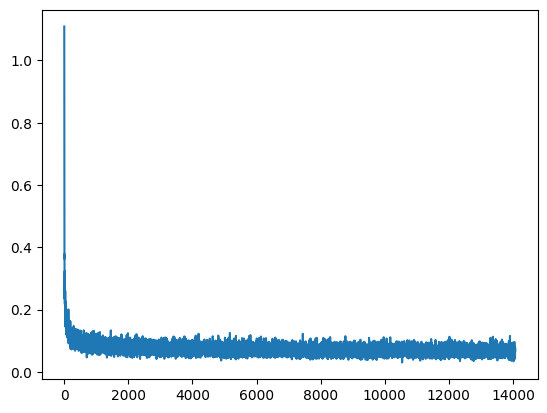

In [ ]:


# Train dataloader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Number of epochs
n_epochs = 15

# Our network
net = class_conditioned_unet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# Adam  optimizer and learning rate of
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Save loss for plot later
losses = []

# Thraditional training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Retrive data and corrupt it with noise
        x = x.to(device) * 2 - 1
        y = y.to(device)
        noise = torch.randn_like(x) # Generate noise
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device) # Determine the dregree in which the image is gradually turned into noise,
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps) # Add noise  for the given timestep

        # Get the model prediction
        pred = net(noisy_x, timesteps, y)

        # Calculate the loss
        loss = loss_fn(pred, noise)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store loss
        losses.append(loss.item())

    # Average of the last 50
    avg_loss = sum(losses[-50:])/50
    print(f'Finished epoch {epoch}. Average of the last 50 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

Once training finishes, we can sample some images feeding in different labels as our conditioning:

In [ ]:



def prediction(a, b):
  a = a # number of images/predictions for each number given as input
  b = b # range of number u want to predict remember we start in zero
  z = a * b
  x = torch.rand(z, 1, 28, 28).to(device)
  y = torch.tensor([[i]*a for i in range(b)]).flatten().to(device)

# Sampling loop
  for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Do model prediction
      with torch.no_grad():
          residual = net(x, t, y)

    # Update sample with step
      x = noise_scheduler.step(residual, t, x).prev_sample

# Results
  fig, ax = plt.subplots(1, 1, figsize=(12, 12))
  ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=b)[0], cmap='Greys')

In [ ]:
text = int(input("Number of predictions for each category: "))
cnt = int(input("Numbers correcspoding to clothes categories you want to predic if e.g. 2 (0, 1) will be predicted: "))
prediction(text, cnt)

In [ ]:
# Exercise (optional): Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decent-looking fashion images with less training time than the example above?